![UB](https://github.com/mayurs142/eas503-project/blob/media/ub_logo.png?raw=true)
# EAS 503 - Project Group 20
### Team Members
> Gaurav Chatterjee <br>
> Mayur Sinha <br>
> Megha Shirodkar

### Introduction
The trip costs of Uber and Lyft are not static like those of public transport. They are hugely impacted at a given time by the demand and supply of trips. So, what exactly drives this demand? The first guess would be the time of the day; the most significant spikes should be seen between 9 AM and 5 PM as people go to work/home. Another explanation is the weather; rain/snow increases the demand for the cabs.
### Data Description
There are two datasets. The cab ride data covers the different types of Uber & Lyft cabs taken and their price for the trip along with any surge. The weather data includes attributes such as temperature, rain, cloud, etc. for the listed locations.
##### Cab Rides
| columns  | description |
|----- | ---- |
| distance | distance covered |
| cab_type | Uber or Lyft |
| time_stamp | epoch time |
| destination | destination of the ride |
| source | source of the ride |
| price | total cab ride fare |
| surge_multiplier | fare multiplier |
| id | unique identifier |
| product_id | Uber/Lyft identifier |
| name | Uber/Lyft cab type |

##### Weather Data
| columns  | description |
|----- | ---- |
| temp | temperature in Fahrenheit
| location | location name
| clouds | cloud forecast in oktas |
| pressure | atmospheric pressure in millibar | 
| rain | rain in inches in the last hour |
| time_stamp | epoch time |
| humidity | humidity in percentage |
| wind | wind in miles per hour |

### Proposed Analysis
The proposed analysis is to evaluate the price of these ride-sharing apps and to decide what factors drive the business. Do different days have different demands? How much weather contribute to the fare of these cab rides.

### Analysis Methods
Analyses techniques employed in the project are:
1. Statistical analysis of the numerical data to organize and summarize data and draw conclusions about cab fares.
2. Predictive analysis to make forecasts about future outcomes of cab fares based on current data.

### Tech Stack
<table><tr>
    <td> <img src="https://github.com/mayurs142/eas503-project/blob/media/python.png?raw=true" alt="Drawing" /> </td>
    <td> <img src="https://github.com/mayurs142/eas503-project/blob/media/sqlite3.png?raw=true" alt="Drawing" /> </td>
</tr></table>

### Project Link
> https://github.com/mayurs142/eas503-project

#### Importing libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

#### Function to make connections to database

In [35]:
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

#### Importing datasets from CSV files into SQLite

In [36]:
import csv
import sqlite3
import glob
import os

def do_directory(csvfiles, db):
    for filename in glob.glob(os.path.join(csvfiles, '*.csv')):
        do_file(filename, db)

def do_file(filename, db):
        with open(filename) as f:
            with db:
                data = csv.DictReader(f)
                cols = data.fieldnames
                table=os.path.splitext(os.path.basename(filename))[0]

                sql = 'drop table if exists "{}"'.format(table)
                db.execute(sql)

                sql = 'create table "{table}" ( {cols} )'.format(
                    table=table,
                    cols=','.join('"{}"'.format(col) for col in cols))
                db.execute(sql)

                sql = 'insert into "{table}" values ( {vals} )'.format(
                    table=table,
                    vals=','.join('?' for col in cols))
                db.executemany(sql, (list(map(row.get, cols)) for row in data))

if __name__ == '__main__':
    conn = sqlite3.connect('uber_lyft_data.db')
    do_directory('.', conn)

#### Inserting database into ``Pandas DataFrame``

In [37]:
db_file = 'uber_lyft_data.db'
conn=create_connection(db_file)
c = conn.cursor()
select_query = "SELECT distance, cab_type, time_stamp, destination, source, price, surge_multiplier, id, product_id, name FROM cab_rides WHERE price != ''"
resoverall = c.execute(select_query)
df_cab = pd.DataFrame(resoverall.fetchall())
df_cab.columns = [i[0] for i in c.description]
conn.close()

In [38]:
df_cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5,1,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11,1,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7,1,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26,1,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9,1,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


#### Converting UNIX epoch time in ``time_stamp`` to date in ``dateandtime``

In [39]:
df_cab = df_cab.convert_objects(convert_numeric=True)
time_stamp_edit = (df_cab['time_stamp']-(df_cab['time_stamp']%1000))/1000
df_cab['dateandtime'] = pd.to_datetime(time_stamp_edit, unit = 's') - pd.Timedelta(hours=5)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


#### SQL query to count the number of cabs from Uber and Lyft 

In [40]:
db_file = 'uber_lyft_data.db'
conn=create_connection(db_file)
c = conn.cursor()
select_query = "SELECT cab_type, COUNT(*) AS id FROM cab_rides GROUP BY cab_type"
resoverall = c.execute(select_query)
df_cab_type_groupby = pd.DataFrame(resoverall.fetchall())
df_cab_type_groupby.columns = [i[0] for i in c.description]
conn.close()

In [41]:
df_cab_type_groupby

,cab_type,id
0,Lyft,307408
1,Uber,385663


#### Plotting the number of cab rides

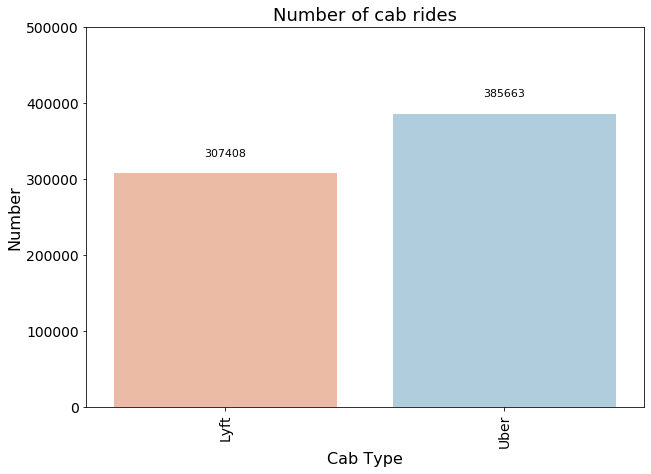

In [42]:
pal = sns.color_palette("RdBu_r", len(df_cab_type_groupby))
plt.figure(figsize=(10,7))
g = sns.barplot(x='cab_type',y='id', data = df_cab_type_groupby,palette=np.array(pal[::-1]))
plt.xlabel("Cab Type",fontsize=16)
plt.ylabel("Number",fontsize=16)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.title("Number of cab rides", fontsize=18)

for p in g.patches:
             g.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,500000)

#### Inference
Uber is preferred 20% more than Lyft

#### Splitting ``dateandtime`` to ``new_date`` and ``new_time`` columns

In [43]:
df_cab['new_date'] = [d.date() for d in df_cab['dateandtime']]
df_cab['new_time'] = [d.time() for d in df_cab['dateandtime']]
df_cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,dateandtime,new_date,new_time
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 04:30:07,2018-12-16,04:30:07
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-26 21:00:23,2018-11-26,21:00:23
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-27 20:00:22,2018-11-27,20:00:22
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-29 23:53:02,2018-11-29,23:53:02
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-28 22:49:20,2018-11-28,22:49:20


In [44]:
df_cab.isnull().sum(axis = 0)

distance            0
cab_type            0
time_stamp          0
destination         0
source              0
price               0
surge_multiplier    0
id                  0
product_id          0
name                0
dateandtime         0
new_date            0
new_time            0
dtype: int64

#### Scatterplot of Price vs Distance for Uber and Lyft

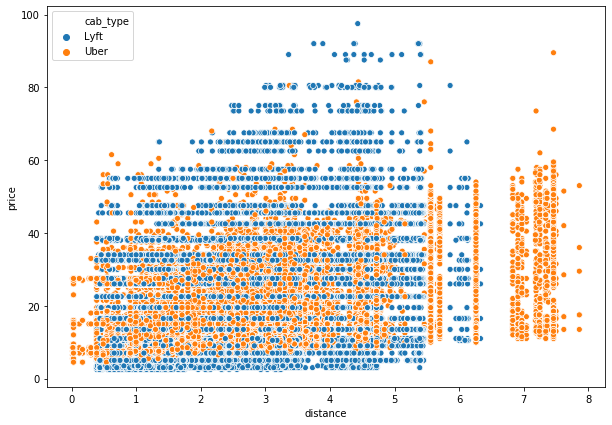

In [45]:
df_cab_dist_price = df_cab[['cab_type','distance','price']]

plt.figure(figsize=(10,7))
sns.scatterplot(x = df_cab_dist_price.distance, y = df_cab_dist_price.price, hue = df_cab_dist_price['cab_type'])

#### Inference
1. Lyft prices are higher than Uber
2. People prefer Lyft for shorter distances
3. People prefer Uber for longer distances

#### Counting the number of cabs booked over the week

In [46]:
df_cab['weekday_number'] = pd.DatetimeIndex(df_cab['new_date']).weekday
lookup = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df_cab['weekday_name'] = df_cab['weekday_number'].apply(lambda x: str(lookup[x]))
groupby_weekday = df_cab.groupby(['weekday_name'])[['id']].count().reset_index()
groupby_weekday

,weekday_name,id
0,Friday,83189
1,Monday,126639
2,Saturday,82708
3,Sunday,87149
4,Thursday,82287
5,Tuesday,86099
6,Wednesday,89905


#### Trend of cab rides over the week in bar plot

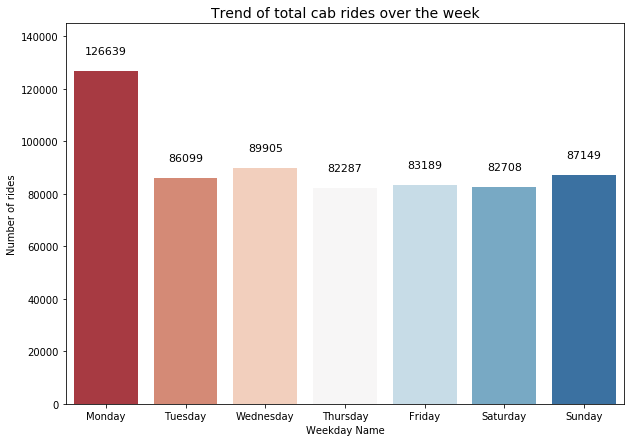

In [47]:
plt.figure(figsize=(10,7))
pal = sns.color_palette("RdBu_r", len(groupby_weekday))
ax1 = sns.barplot(x='weekday_name',y='id', data = groupby_weekday,order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette=np.array(pal[::-1]))
plt.title("Trend of total cab rides over the week", fontsize=14)
plt.xlabel("Weekday Name")
plt.ylabel("Number of rides")

for p in ax1.patches:
             ax1.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
_ = ax1.set_ylim(0,145000)

#### Inference
1. Monday has abnormally more rides booked as compared to other days
2. Rest of the days have approximately the same number of rides

#### SQL query to get details of rainy days

In [48]:
db_file = 'uber_lyft_data.db'
conn=create_connection(db_file)
c = conn.cursor()
select_query = "SELECT location,time_stamp,rain FROM weather "
resoverall = c.execute(select_query)
df_weather_rain = pd.DataFrame(resoverall.fetchall())
df_weather_rain.columns = [i[0] for i in c.description]
conn.close()

In [49]:
df_weather_rain.head()
time_stamp_edit_w = df_weather_rain['time_stamp']
df_weather_rain['dateandtime'] = pd.to_datetime(time_stamp_edit_w, unit = 's') - pd.Timedelta(hours=5)
df_cab['locationanddate'] = df_cab.source.astype(str) +" - "+ df_cab.dateandtime.dt.date.astype(str) +" - "+ df_cab.dateandtime.dt.hour.astype(str)
df_weather_rain['locationanddate'] = df_weather_rain.location.astype(str) +" - "+ df_weather_rain.dateandtime.dt.date.astype(str) +" - "+ df_weather_rain.dateandtime.dt.hour.astype(str)

In [50]:
df_merge = pd.merge(df_cab ,df_weather_rain,how='left', left_on=['locationanddate'], right_on=['locationanddate'])
df_merge['rain']=df_merge['rain'].fillna(0)
df_merge = df_merge.convert_objects(convert_numeric=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Trend of cab rides booked on rainy days in bar plot

In [51]:
df_rain_cab = df_merge.groupby(['weekday_name'])[['rain']].sum().reset_index()

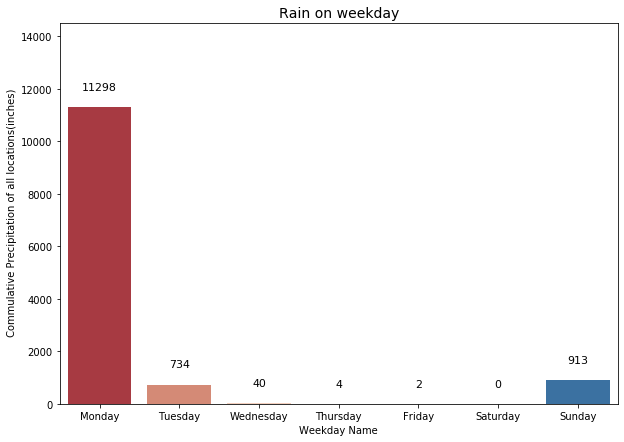

In [52]:
plt.figure(figsize=(10,7))
pal = sns.color_palette("RdBu_r", len(df_rain_cab))
ax2 = sns.barplot(x='weekday_name',y='rain', data = df_rain_cab,order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette=np.array(pal[::-1]))

plt.title("Rain on weekday", fontsize=14)
plt.xlabel("Weekday Name")
plt.ylabel(" Commulative Precipitation of all locations(inches)")

for p in ax2.patches:
             ax2.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
_ = ax2.set_ylim(0,14500)

#### Inference
Since Mondays had abnormally more rides compared to other days, people preferred to take a cab when their is rainfall

#### SQL query to find the count of different types of Uber cabs

In [53]:
db_file = 'uber_lyft_data.db'
conn=create_connection(db_file)
c = conn.cursor()
select_query = "SELECT name, COUNT(id) AS id FROM cab_rides WHERE cab_type ='Uber' GROUP BY name "
resoverall = c.execute(select_query)
df_uber_group = pd.DataFrame(resoverall.fetchall())
df_uber_group.columns = [i[0] for i in c.description]
conn.close()
df_uber_group

,name,id
0,Black,55095
1,Black SUV,55096
2,Taxi,55095
3,UberPool,55091
4,UberX,55094
5,UberXL,55096
6,WAV,55096


#### SQL query to find the count of different types of Lyft cabs

In [54]:
db_file = 'uber_lyft_data.db'
conn=create_connection(db_file)
c = conn.cursor()
select_query = "SELECT name, COUNT(id) AS id FROM cab_rides WHERE cab_type ='Lyft' GROUP BY name "
resoverall = c.execute(select_query)
df_lyft_group = pd.DataFrame(resoverall.fetchall())
df_lyft_group.columns = [i[0] for i in c.description]
conn.close()

df_lyft_group

,name,id
0,Lux,51235
1,Lux Black,51235
2,Lux Black XL,51235
3,Lyft,51235
4,Lyft XL,51235
5,Shared,51233


#### Scatterplot of prices of different types of Uber and Lyft cabs vs the distance

Text(0.5, 1.0, 'Lyft prices over the week')

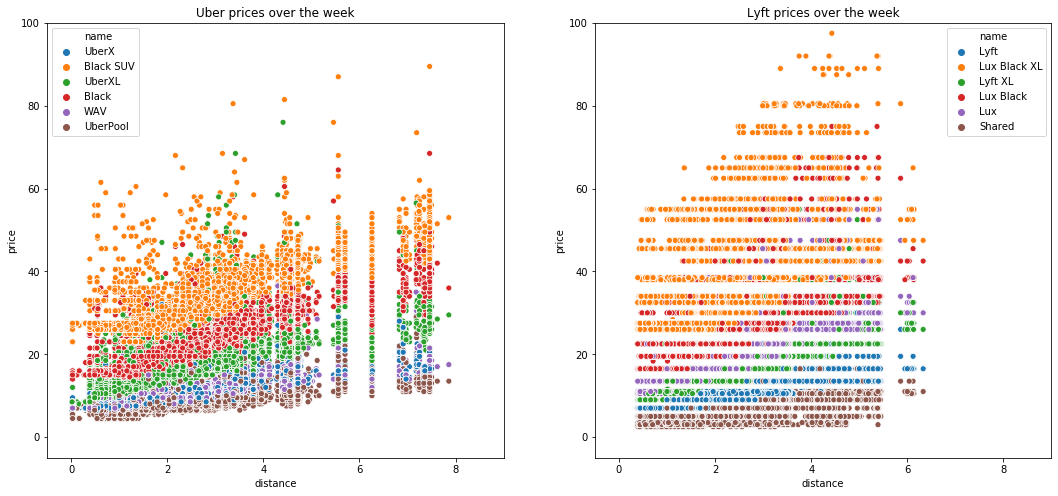

In [55]:
df_lyft = df_cab[df_cab['cab_type']=='Lyft']
df_uber = df_cab[df_cab['cab_type']=='Uber']

U1=['UberX','Black SUV','UberXL','Black','WAV','UberPool']
L1=['Lyft','Lux Black XL','Lyft XL','Lux Black','Lux','Shared']

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt1 = sns.scatterplot(x=df_uber.distance,y=df_uber.price ,hue = df_uber['name'], hue_order = U1)
plt.subplot(1,2,2)
plt2 = sns.scatterplot(x=df_lyft.distance,y=df_lyft.price ,hue = df_lyft['name'], hue_order = L1)
plt1.set(ylim=(-5, 100))
plt2.set(ylim=(-5, 100))
plt1.set(xlim=(-0.5, 9))
plt2.set(xlim=(-0.5, 9))
plt1.set_title('Uber prices over the week')
plt2.set_title('Lyft prices over the week')

#### Inference
1. Lyft Shared cabs have lower prices as compared to Uber Pool
2. Lyft Luxury cabs are more expensive than Uber

#### Scatterplot of prices of UberPool and Lyft Shared vs distance

In [56]:
df_uber_less_than_50 = df_uber[df_uber['name'] == 'UberPool']
df_uber_less_than_50_group = df_uber_less_than_50.groupby(['name'])[['id']].count().reset_index()
df_uber_less_than_50_group

,name,id
0,UberPool,55091


In [57]:
df_lyft_less_than_50 = df_lyft[df_lyft['name'] == 'Shared']
df_lyft_less_than_50_group = df_lyft_less_than_50.groupby(['name'])[['id']].count().reset_index()
df_lyft_less_than_50_group

,name,id
0,Shared,51233


Text(0.5, 1.0, 'Lyft prices over the week')

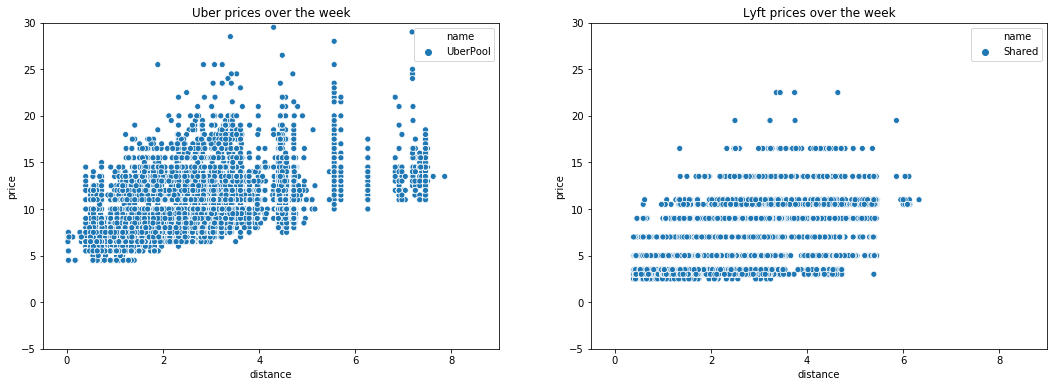

In [58]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt1 = sns.scatterplot(x=df_uber_less_than_50.distance,y=df_uber_less_than_50.price ,hue = df_uber_less_than_50['name'])
plt.subplot(1,2,2)
plt2 = sns.scatterplot(x=df_lyft_less_than_50.distance,y=df_lyft_less_than_50.price ,hue = df_lyft_less_than_50['name'])
plt1.set(ylim=(-5, 30))
plt2.set(ylim=(-5, 30))
plt1.set(xlim=(-0.5, 9))
plt2.set(xlim=(-0.5, 9))
plt1.set_title('Uber prices over the week')
plt2.set_title('Lyft prices over the week')

#### Inference
Uber Pool is expensive than Lyft Shared

#### Line Plot of Peak Hours

In [59]:
def bin_f(x):
    #print(x.time())
    #print(datetime.time(4))
    if x.time() < datetime.time(2):
        return "00:00-01:59"
    elif x.time() < datetime.time(4):
        return "02:00-03:59"
    elif x.time() < datetime.time(6):
        return "04:00-05:59"
    elif x.time() < datetime.time(8):
        return "06:00-07:59"
    elif x.time() < datetime.time(10):
        return "08:00-09:59"
    elif x.time() < datetime.time(12):
        return "10:00-11:59"
    elif x.time() < datetime.time(14):
        return "12:00-13:59"
    elif x.time() < datetime.time(16):
        return "14:00-15:59"
    elif x.time() < datetime.time(18):
        return "16:00-17:59"
    elif x.time() < datetime.time(20):
        return "18:00-19:59"
    elif x.time() < datetime.time(22):
        return "20:00-21:59"
    else:
        return "22:00-23:59"
df_cab['Bin'] = df_cab['dateandtime'].apply(bin_f)

In [60]:
df_cab_group_time = df_cab.groupby(['Bin'])[['id']].count().reset_index()
df_cab_group_time

,Bin,id
0,00:00-01:59,48142
1,02:00-03:59,45267
2,04:00-05:59,54591
3,06:00-07:59,55963
4,08:00-09:59,55953
5,10:00-11:59,55840
6,12:00-13:59,56033
7,14:00-15:59,50030
8,16:00-17:59,52642
9,18:00-19:59,59227


Text(0.5, 1.0, 'Peak Hour')

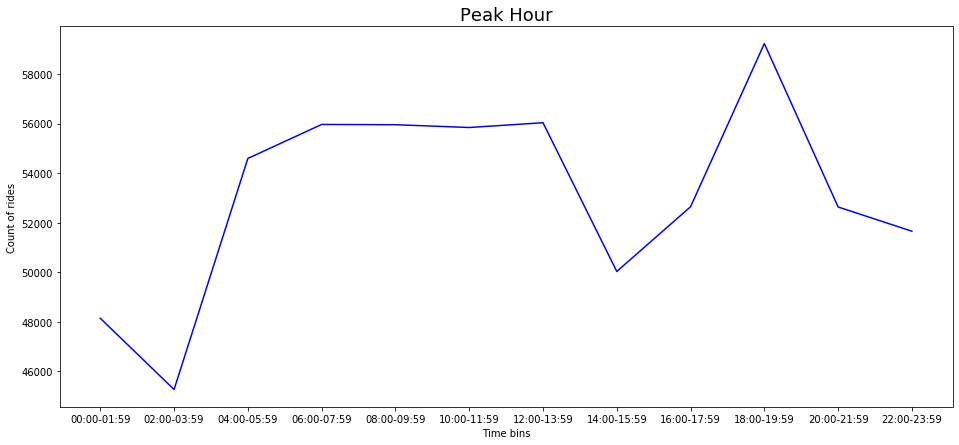

In [61]:
plt.figure(figsize=(16,7))
plot=sns.lineplot(x = 'Bin', y = 'id', data = df_cab_group_time, color='blue', palette='ch:5,.25' )
plt.xlabel("Time bins")
plt.ylabel("Count of rides")
plt.title("Peak Hour", fontsize=18)

#### Inference
Maximum rides were booked during 18.00 – 20.00, generally during the end of office hours.

In [62]:
db_file = 'uber_lyft_data.db'
conn=create_connection(db_file)
c = conn.cursor()
select_query = "SELECT temp,location,clouds,pressure,rain,time_stamp,humidity,wind FROM weather ORDER BY time_stamp "
resoverall = c.execute(select_query)
df_weather = pd.DataFrame(resoverall.fetchall())
df_weather.columns = [i[0] for i in c.description]
conn.close()

In [63]:
time_stamp_edit_w = df_weather['time_stamp']
df_weather['dateandtime'] = pd.to_datetime(time_stamp_edit_w, unit = 's') - pd.Timedelta(hours=5)
df_weather['locationanddate'] = df_weather.location.astype(str) +" - "+ df_weather.dateandtime.dt.date.astype(str) +" - "+ df_weather.dateandtime.dt.hour.astype(str)

In [64]:
df_merge_all = pd.merge(df_cab ,df_weather,how='left', left_on=['locationanddate'], right_on=['locationanddate'])
df_merge_all = df_merge_all.convert_objects(convert_numeric=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [65]:
df_merge_all = df_merge_all[pd.notnull(df_merge_all['dateandtime_y'])]
df_merge_all['rain'].fillna(0, inplace = True)
df_merge_all['hour'] = df_merge_all.dateandtime_y.dt.hour
df_merge_all['day'] = df_merge_all.dateandtime_y.dt.dayofweek

In [66]:
df_merge_lyft = df_merge_all[df_merge_all['product_id']=='lyft_line']

In [67]:
X = df_merge_lyft[['day','distance','hour','rain']]
y = df_merge_lyft[['price']]

In [68]:
X.head()

,day,distance,hour,rain
0,6,0.44,4,0.0000
18,0,1.08,1,0.0000
35,3,0.72,21,0.0000
48,0,3.24,22,0.2420
49,0,3.24,22,0.1617


#### Analysis using Forest Regression model to predict prices of cab rides

In [69]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 80)

In [70]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(75009, 4) (18753, 4) (75009, 1) (18753, 1)


In [71]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
y_pred = regressor.predict(X_test)

In [73]:
errors = abs(y_pred - y_test)

In [74]:
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: price    77.3
dtype: float64 %.


In [75]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)
# Train the model on training data
rf.fit(X_train, y_train) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=5, verbose=0,
                      warm_start=False)

In [76]:
y_test = y_test.values.ravel()
predictions = rf.predict(X_test)
# Calculate the absolute errors


In [77]:
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.93 degrees.


In [79]:
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 81.76 %.


#### Prediction of prices with an accuracy of 81.76 %